<a href="https://colab.research.google.com/github/dprasadk/Bronchitis-Detection-for-Apollo/blob/master/RSNA_Pneumonia_Detection_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### [Kaggle](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge) :  RSNA Pneumonia Detection Challenge
> The objective of this challenge is to  build an algorithm to detect a visual signal for pneumonia in medical images. Where algorithm needs to automatically locate lung opacities on chest radiographs.

####__author__: Durga PrasadK

### Install required packages

In [0]:
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q Keras==2.2.4
!pip3 install -q TensorFlow==1.10
 
 

import os
import io
import gc

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
import pydicom
import glob
import keras.preprocessing.image as KPImage

from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout,  BatchNormalization, Input,Flatten
# from keras.preprocessing.image import ImageDataGenerator
 
from keras.applications.vgg16 import VGG16 , preprocess_input
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras import layers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


## Kaggle Set UP

In [0]:
!pip3 install -q kaggle

from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload

from google.colab import auth
auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)


Download 100%.


## Set up local directories

In [0]:
# Root directory of the project
ROOT_DIR = os.path.abspath('/content/kaggle/')

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!pwd

/content/kaggle


##Download Kaggle Data Sets

In [0]:
# Download Datasets 
!kaggle competitions download -c rsna-pneumonia-detection-challenge  

  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 39.6MB/s]
  0% 0.00/155k [00:00<?, ?B/s]
100% 155k/155k [00:00<00:00, 47.4MB/s]
  0% 0.00/661k [00:00<?, ?B/s]
100% 661k/661k [00:00<00:00, 43.7MB/s]
 98% 369M/377M [00:04<00:00, 93.2MB/s]
100% 377M/377M [00:04<00:00, 81.8MB/s]
100% 3.28G/3.29G [00:49<00:00, 89.4MB/s]
100% 3.29G/3.29G [00:49<00:00, 71.1MB/s]
  0% 0.00/55.0 [00:00<?, ?B/s]
100% 55.0/55.0 [00:00<00:00, 60.9kB/s]


In [0]:
!ls /content/kaggle

GCP%20Credits%20Request%20Link%20-%20RSNA.txt  stage_2_test_images.zip
stage_2_detailed_class_info.csv.zip	       stage_2_train_images.zip
stage_2_sample_submission.csv		       stage_2_train_labels.csv.zip


In [0]:
# unzip DataSets into respective folders
!unzip  stage_2_train_images.zip -d /content/kaggle/Train
!unzip  stage_2_test_images.zip -d /content/kaggle/Test
!unzip  stage_2_train_labels.csv.zip -d /content/kaggle/Labels
!unzip  stage_2_detailed_class_info.csv.zip -d /content/kaggle/Class

Archive:  stage_2_train_images.zip
  inflating: /content/kaggle/Train/a4a28a4f-9496-430c-8cc1-cff2b44ac359.dcm  
  inflating: /content/kaggle/Train/93a4df4f-bb28-4f02-9e1d-4fc147a93be5.dcm  
  inflating: /content/kaggle/Train/ecf0161e-f058-4166-825e-4e1d5bf98d1e.dcm  
  inflating: /content/kaggle/Train/995876a0-f2ae-475b-b410-62fd0aff7f3c.dcm  
  inflating: /content/kaggle/Train/f4113fee-b7a0-472c-8f68-24e999fbf73a.dcm  
  inflating: /content/kaggle/Train/3d8ec01f-d488-4816-8fee-036b69b43246.dcm  
  inflating: /content/kaggle/Train/5fb17b91-e490-4f40-bc6b-7955028058c8.dcm  
  inflating: /content/kaggle/Train/af4d7012-0021-4729-8eda-a8393698cf33.dcm  
  inflating: /content/kaggle/Train/66830592-46b6-4907-9c06-845338b63fa2.dcm  
  inflating: /content/kaggle/Train/edbc1975-81dd-4296-90f6-708e3f67e81a.dcm  
  inflating: /content/kaggle/Train/5d8dbcf9-0d68-4aec-8638-b0a9f45d71d6.dcm  
  inflating: /content/kaggle/Train/c8b4cab0-ad2f-43dd-96e4-cd6b81f93a6a.dcm  
  inflating: /content/kaggle/

## Exploratory Pneumonia Data Anylysis

In [0]:
class_path  = '/content/kaggle/Class/stage_2_detailed_class_info.csv'
labels_path = '/content/kaggle/Labels/stage_2_train_labels.csv'
train_dir   = '/content/kaggle/Train'
test_dir    = '/content/kaggle/Test'

> ####  Analysis for Stage 2 patients class information

30227 class information loaded
26684 patient cases


patientId                         class
13048  83c2c654-5bc2-41c4-b53d-054888e022d6                  Lung Opacity
2790   3434889e-68e9-416d-bf95-ca21275eda5e                  Lung Opacity
17485  a6f7b5e6-398a-496b-8bae-c75d1d567d0d                        Normal
9326   6689ede5-88a2-4e31-8410-97694b323f0c  No Lung Opacity / Not Normal
1640   17af0269-b24a-462b-bb27-01ca17cb6494  No Lung Opacity / Not Normal
11361  763adcfd-4ebf-4d3b-91bd-a7813dc4bb96                        Normal
23440  d2fc0e11-ee88-4065-80ba-2c061c2f1bd9  No Lung Opacity / Not Normal
12854  82229823-adbb-481c-93f9-d80e7fb61442                        Normal
25586  e51897c6-933b-4ebb-aa97-ad71c7298de7                        Normal
8916   63583781-88e5-4ac2-b4b1-d7d8541c1a45                        Normal

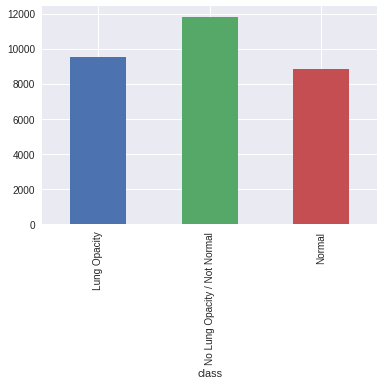

In [0]:
df_class = pd.read_csv(class_path)
print(df_class.shape[0], 'class information loaded')
print(df_class['patientId'].value_counts().shape[0], 'patient cases')
df_class.groupby('class').size().plot.bar()
df_class.sample(10)

>  ####  Analysis for Stage 2 patients labels information

30227 labels loaded
26684 patient cases


patientId      x      y  width  height  \
3948   3bbc434c-d221-4f9e-9c91-e1740df807e0    NaN    NaN    NaN     NaN   
29729  239e9d1c-e5c1-4798-a6ba-64fd64e7c486  701.0  435.0  160.0   276.0   
20357  ba99dd86-de1a-4bd6-a16e-b6a98e558507    NaN    NaN    NaN     NaN   
24968  e01bd4b1-8c24-4fd7-9b8a-7888f52bfd80    NaN    NaN    NaN     NaN   
24499  dc1ff256-d678-4d7d-b4b9-6254ed110f4b    NaN    NaN    NaN     NaN   
16513  9fa14682-ad76-4df6-80a6-aa623e59ff4c    NaN    NaN    NaN     NaN   
8278   5e2f7515-0995-4dd4-8bbe-753fbcf304b4    NaN    NaN    NaN     NaN   
15392  967f1858-3edd-4247-a19e-a36510656024    NaN    NaN    NaN     NaN   
3594   395738ff-53d2-42e6-aa6d-a01e4a07f01f  274.0  468.0  239.0   414.0   
20498  bb7a3a54-44b3-48b3-8856-cfbf9dcc1f75    NaN    NaN    NaN     NaN   

       Target  
3948        0  
29729       1  
20357       0  
24968       0  
24499       0  
16513       0  
8278        0  
15392       0  
3594        1  
20498       0

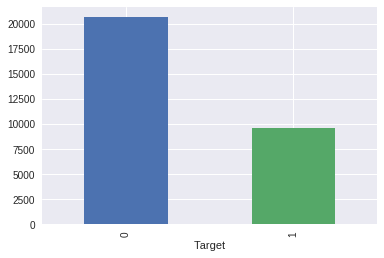

In [0]:
df_labels = pd.read_csv(labels_path)
print(df_labels.shape[0], 'labels loaded')
print(df_labels['patientId'].value_counts().shape[0], 'patient cases')
df_labels.groupby('Target').size().plot.bar()
df_labels.sample(10)

> #### Map labels path with class_path

In [0]:
df_map_labels_class = pd.merge(df_labels, df_class, how='inner', on='patientId')
print(df_map_labels_class.shape[0], 'combined cases')

37629 combined cases


In [0]:
# Drop duplicate Classes
df_map_labels_class = pd.concat([df_labels, df_class.drop('patientId',1)], 1)
print(df_map_labels_class.shape[0], 'combined cases')
df_map_labels_class.sample(10)

30227 combined cases


patientId      x      y  width  height  \
19838  b753fa88-2247-4354-86e7-c0031fe11d13    NaN    NaN    NaN     NaN   
3025   359ce100-a41f-40e2-ba95-c91b83725a35  169.0  321.0  190.0   394.0   
16974  a3476eba-8536-4271-a7a9-b13dc3cc8a4d  592.0  490.0  244.0   471.0   
7894   5adf75a4-81c5-4d9c-959b-6b9831babdd6    NaN    NaN    NaN     NaN   
1298   1436886b-785a-4767-a078-c02510681c3a    NaN    NaN    NaN     NaN   
18682  afa1bff5-3158-4bd5-bfe4-e85bcd3577d7  185.0  160.0  225.0   437.0   
11406  76b14eb0-e55a-48f6-86d9-4dbc8353df17    NaN    NaN    NaN     NaN   
2081   24bc6cbc-3ed9-455a-8fbf-f106ce3e1e59  223.0  585.0  136.0   142.0   
15823  99dc9429-ef5b-4a04-93ae-512b006e8dc4    NaN    NaN    NaN     NaN   
16295  9deec23f-8bc9-4957-8b3e-be5c7abf2e87    NaN    NaN    NaN     NaN   

       Target                         class  
19838       0                        Normal  
3025        1                  Lung Opacity  
16974       1                  Lung Opacity  
7894        0  No Lung Opacity / Not Normal  
1298        0                        Normal  
18682       1                  Lung Opacity  
11406       0                        Normal  
2081        1                  Lung Opacity  
15823       0                        Normal  
16295       0                        Normal

> #### Distinct count of labels with Patient ID

In [0]:
df_label = df_map_labels_class.groupby('patientId').size().reset_index(name='labels')
df_label.sample(20)

patientId  labels
7752   5b684669-0ee0-44ff-851b-e2f6146c7e30       1
18510  b8d5cabd-d5b5-4ac4-b1d1-f0f80be47619       1
1713   17a1427c-70b0-4383-b5f3-a2b5f1ec0691       2
18225  b63f4c12-5731-41e2-8d89-2ae0c4daba41       2
6577   50e23909-1da4-4eb7-acc7-9424d47faae1       1
19767  c46329fa-c464-4bf4-b60a-3e2796c97357       1
1756   17e95c76-ae2f-4ad9-b713-08b617d3c9bd       2
13601  8e09afee-7a2c-4a53-84ed-ed2dad8d02be       1
9824   6ca29744-a746-401b-b774-66190b3c25d4       1
20312  c8e6f96f-eda7-428c-a5aa-db10331902ef       1
12922  882dbf8f-8f01-46ad-b6d4-109db0ee4cdc       1
13581  8dda3f06-b2fe-40ca-ae22-6457c956c3bf       2
9037   66572a9d-0907-494b-8fe5-3d3771ab9455       1
25289  f403aa91-e52c-41b5-8d86-af6c5546cbf1       1
19266  bf1da0dc-850f-47e9-aad9-a5a94d6e67bd       2
9615   6b013c90-ec73-4a7a-a607-17540c493e0f       2
11499  7b3e032d-e3ec-4c61-8a49-785fd6d0d87e       1
15973  a2f902b1-e52d-4d17-bc4f-a407138f7313       1
7033   54eb650c-09f4-43fe-8ba8-6ea720264253       1
14169  933fac42-c276-40dd-8106-bc72c8d2ecbd       1

In [0]:
## Cross check 
print(df_map_labels_class.loc[df_map_labels_class['patientId'] =='41560731-6e3f-44b9-b951-e789bb8e0cc8'])

                                 patientId      x      y  width  height  \
4783  41560731-6e3f-44b9-b951-e789bb8e0cc8  263.0  630.0  264.0   243.0   
4784  41560731-6e3f-44b9-b951-e789bb8e0cc8  617.0  627.0  319.0   306.0   

      Target         class  
4783       1  Lung Opacity  
4784       1  Lung Opacity  


In [0]:
df_map_labels_class.shape

(30227, 7)

> #### Distinct count of labels based on Patients

In [0]:
df_map_labels_class = pd.merge(df_map_labels_class, df_label, on='patientId')
df_label.groupby('labels').size().reset_index(name='patients')

labels  patients
0       1     23286
1       2      3266
2       3       119
3       4        13

> #### Distinct of classes and Targets based on Patient Count

In [0]:
df_map_labels_class.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

class  Target  Patient Count
0                  Lung Opacity       1           9555
1  No Lung Opacity / Not Normal       0          11821
2                        Normal       0           8851

> #### Analysis for Stage 2 Training Images

In [0]:
# Pull the image path name into the dataframe
df_train_images = pd.DataFrame({'path': glob.glob(os.path.join(train_dir, '*.dcm'))})

# Spilt the base name of Patient name and genearate a new feature
df_train_images['patientId'] = df_train_images['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])

#Look for total counts.
print("Total count for Images exists in images directory :", + df_train_images['patientId'].shape[0])
print("Total count for Images exists in class file :", + df_map_labels_class['patientId'].shape[0])

# Perfrom Union operation 
union_img_pat_ids = set(df_train_images['patientId'].values.tolist())
union_lab_pat_ids = set(df_map_labels_class['patientId'].values.tolist())

# Assert is a part of JUNIT, here we are making sure that Patient ID should be 
# same, if patient ID's not same then the below statement will fails due to 
# assertion error statement
assert union_img_pat_ids.union(union_lab_pat_ids)==union_img_pat_ids

Total count for Images exists in images directory : 26684
Total count for Images exists in class file : 30227


> #### Mapping df_Train_images Dataframes with existing Dataframe df_map_labels_class based on patientID




In [0]:
df_image_dataset = pd.merge(df_map_labels_class , 
                                      df_train_images, 
                                      on='patientId',
                                      how='left').\
                                    sort_values('patientId')
print("Total count for final image dataset for Model Building :", + df_image_dataset.shape[0])
df_image_dataset.head(10)

Total count for final image dataset for Model Building : 30227


patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
28989  000924cf-0f8d-42bd-9158-1af53881a557    NaN    NaN    NaN     NaN   
28990  000db696-cf54-4385-b10b-6b16fbb3f985  316.0  318.0  170.0   478.0   
28991  000db696-cf54-4385-b10b-6b16fbb3f985  660.0  375.0  146.0   402.0   
28992  000fe35a-2649-43d4-b027-e67796d412e0  570.0  282.0  269.0   409.0   
28993  000fe35a-2649-43d4-b027-e67796d412e0   83.0  227.0  296.0   438.0   
28994  001031d9-f904-4a23-b3e5-2c088acd19c6   66.0  160.0  373.0   608.0   
28995  001031d9-f904-4a23-b3e5-2c088acd19c6  552.0  164.0  376.0   676.0   
28996  0010f549-b242-4e94-87a8-57d79de215fc    NaN    NaN    NaN     NaN   
28997  001916b8-3d30-4935-a5d1-8eaddb1646cd  198.0  375.0  114.0   206.0   

       Target                         class  labels  \
0           0  No Lung Opacity / Not Normal       1   
28989       0                        Normal       1   
28990       1                  Lung Opacity       2   
28991       1                  Lung Opacity       2   
28992       1                  Lung Opacity       2   
28993       1                  Lung Opacity       2   
28994       1                  Lung Opacity       2   
28995       1                  Lung Opacity       2   
28996       0                        Normal       1   
28997       1                  Lung Opacity       1   

                                                    path  
0      /content/kaggle/Train/0004cfab-14fd-4e49-80ba-...  
28989  /content/kaggle/Train/000924cf-0f8d-42bd-9158-...  
28990  /content/kaggle/Train/000db696-cf54-4385-b10b-...  
28991  /content/kaggle/Train/000db696-cf54-4385-b10b-...  
28992  /content/kaggle/Train/000fe35a-2649-43d4-b027-...  
28993  /content/kaggle/Train/000fe35a-2649-43d4-b027-...  
28994  /content/kaggle/Train/001031d9-f904-4a23-b3e5-...  
28995  /content/kaggle/Train/001031d9-f904-4a23-b3e5-...  
28996  /content/kaggle/Train/0010f549-b242-4e94-87a8-...  
28997  /content/kaggle/Train/001916b8-3d30-4935-a5d1-...

> #### Analysis for Images meta data

>  #### Generate CSV file

In [0]:
df_image_dataset.to_csv('df_image_dataset_final.csv', index=False)

In [0]:
!ls /content/kaggle/df_image_dataset_final.csv

/content/kaggle/df_image_dataset_final.csv


## Model Building 

In [0]:

network_config =   {"BASE_MODEL": "VGG16"  ,
           "IMG_SIZE" : (384, 384) ,
           "BATCH_SIZE" : 24 , 
            "DENSE_COUNT" : 128 ,
            "DROPOUT" : 0.25 , 
            "LEARN_RATE" : 1e-4 , 
            "TRAIN_SAMPLES" : 8000, 
            "TEST_SAMPLES" : 800,
            "USE_ATTN" : "False",
            "DATA_SET" : "/content/kaggle/df_image_dataset_final.csv",
            "TRAIN_JPG_DIR" : "/content/kaggle/train_jpg_dir",
            "TEST_JPG_DIR"  : "/content/kaggle/test_jpg_dir"    }
          

#### Keras Image Transplantion from DICOM to JPG, since keras engine supports JPG Format ,

In [0]:
def dicom_to_jpg(in_file, out_file, out_size):
    """ Convert dicom file to jpg with specified size """
    ds = pydicom.read_file(in_file)
    size = (ds.Columns, ds.Rows)
    mode = 'L'
    im = Image.frombuffer(mode, size, ds.pixel_array,
                          "raw", mode, 0, 1).convert("L")
    im = im.resize((out_size, out_size), resample=Image.BICUBIC)
    im.save(out_file, quality=95)

In [0]:
out_size = 384
train_jpg_dir = network_config["TRAIN_JPG_DIR"]
if not os.path.exists(train_jpg_dir):
    os.mkdir(train_jpg_dir)
for i, dcm_file in enumerate(glob.glob(os.path.join(train_dir, "*.dcm"))):
  bn = os.path.basename(dcm_file)
  out_file = os.path.join(train_jpg_dir, bn[:-4]+".jpg")
  print(f"Converting training image # {i+1}\r", end="")
  print(dcm_file)
  dicom_to_jpg(dcm_file, out_file, out_size)
print()

test_jpg_dir = network_config["TEST_JPG_DIR"]
if not os.path.exists(test_jpg_dir):
    os.mkdir(test_jpg_dir)
for i, dcm_file in enumerate(glob.glob(os.path.join(test_dir, "*.dcm"))):
  bn = os.path.basename(dcm_file)
  out_file = os.path.join(test_jpg_dir, bn[:-4]+".jpg")
  print(f"Converting test image # {i+1}\r", end="")
  dicom_to_jpg(dcm_file, out_file, out_size)
print()

In [0]:
!ls /content/kaggle/train_jpg_dir

0004cfab-14fd-4e49-80ba-63a80b6bddd6.jpg
000924cf-0f8d-42bd-9158-1af53881a557.jpg
000db696-cf54-4385-b10b-6b16fbb3f985.jpg
000fe35a-2649-43d4-b027-e67796d412e0.jpg
001031d9-f904-4a23-b3e5-2c088acd19c6.jpg
0010f549-b242-4e94-87a8-57d79de215fc.jpg
001916b8-3d30-4935-a5d1-8eaddb1646cd.jpg
0022073f-cec8-42ec-ab5f-bc2314649235.jpg
0022995a-45eb-4cfa-9a59-cd15f5196c64.jpg
0025d2de-bd78-4d36-9f72-e15a5e22ca82.jpg
00293de0-a530-41dc-9621-0b3def01d06d.jpg
002c591d-df62-4e34-8eda-838c664430a9.jpg
002cb550-2e31-42f1-a29d-fbc279977e71.jpg
00313ee0-9eaa-42f4-b0ab-c148ed3241cd.jpg
00322d4d-1c29-4943-afc9-b6754be640eb.jpg
003d8fa0-6bf1-40ed-b54c-ac657f8495c5.jpg
00436515-870c-4b36-a041-de91049b9ab4.jpg
0049f7b2-229b-4a46-91a3-0e321a3ca80a.jpg
0053ee32-1e03-4dc2-a103-f46ad0448787.jpg
00569f44-917d-4c86-a842-81832af98c30.jpg
005f5517-ab76-4b0d-8a26-f808d97171c4.jpg
0067d70b-0e6d-41ff-a9b8-8edf6d5e25e4.jpg
006cec2e-6ce2-4549-bffa-eadfcd1e9970.jpg
006e75c8-1fd9-4a5a-99e7-285addebed55.jpg
00704310-78a8-4b

In [0]:
df_image_dataset_final = pd.read_csv(network_config["DATA_SET"])

print(df_image_dataset_final.shape[0], 'images')
df_image_dataset_final.sample(3)

30227 images


patientId      x      y  width  height  \
2133   180702e4-92dc-481f-b6dc-23419ef8a0c5    NaN    NaN    NaN     NaN   
20214  b20b2346-f86c-45b5-aeea-a4b10e35b764  628.0  210.0  236.0   363.0   
20251  b24bde0d-d372-4522-b8bb-0fbc770b80ac   68.0  293.0  240.0   451.0   

       Target         class  labels  \
2133        0        Normal       1   
20214       1  Lung Opacity       2   
20251       1  Lung Opacity       2   

                                                    path  
2133   /content/kaggle/Train/180702e4-92dc-481f-b6dc-...  
20214  /content/kaggle/Train/b20b2346-f86c-45b5-aeea-...  
20251  /content/kaggle/Train/b24bde0d-d372-4522-b8bb-...

In [0]:
df_train_jpg = pd.DataFrame({'path': glob.glob('/content/kaggle/train_jpg_dir/*.jpg')})
df_train_jpg['patientId'] = df_train_jpg['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
df_image_dataset_final = df_image_dataset_final.drop('path', axis = 1).copy()
df_image_dataset_final = pd.merge(df_image_dataset_final, df_train_jpg, how='inner', on='patientId')

In [0]:
df_image_dataset_final

patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
1      000924cf-0f8d-42bd-9158-1af53881a557    NaN    NaN    NaN     NaN   
2      000db696-cf54-4385-b10b-6b16fbb3f985  316.0  318.0  170.0   478.0   
3      000db696-cf54-4385-b10b-6b16fbb3f985  660.0  375.0  146.0   402.0   
4      000fe35a-2649-43d4-b027-e67796d412e0  570.0  282.0  269.0   409.0   
5      000fe35a-2649-43d4-b027-e67796d412e0   83.0  227.0  296.0   438.0   
6      001031d9-f904-4a23-b3e5-2c088acd19c6   66.0  160.0  373.0   608.0   
7      001031d9-f904-4a23-b3e5-2c088acd19c6  552.0  164.0  376.0   676.0   
8      0010f549-b242-4e94-87a8-57d79de215fc    NaN    NaN    NaN     NaN   
9      001916b8-3d30-4935-a5d1-8eaddb1646cd  198.0  375.0  114.0   206.0   
10     0022073f-cec8-42ec-ab5f-bc2314649235  161.0  230.0  223.0   486.0   
11     0022073f-cec8-42ec-ab5f-bc2314649235  575.0  232.0  246.0   528.0   
12     0022995a-45eb-4cfa-9a59-cd15f5196c64    NaN    NaN    NaN     NaN   
13     0025d2de-bd78-4d36-9f72-e15a5e22ca82    NaN    NaN    NaN     NaN   
14     00293de0-a530-41dc-9621-0b3def01d06d    NaN    NaN    NaN     NaN   
15     002c591d-df62-4e34-8eda-838c664430a9    NaN    NaN    NaN     NaN   
16     002cb550-2e31-42f1-a29d-fbc279977e71  176.0  342.0  170.0   239.0   
17     002cb550-2e31-42f1-a29d-fbc279977e71  515.0  333.0  167.0   251.0   
18     00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN   
19     00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN   
20     003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN   
21     00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0   
22     00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0   
23     0049f7b2-229b-4a46-91a3-0e321a3ca80a    NaN    NaN    NaN     NaN   
24     0053ee32-1e03-4dc2-a103-f46ad0448787    NaN    NaN    NaN     NaN   
25     00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN   
26     005f5517-ab76-4b0d-8a26-f808d97171c4    NaN    NaN    NaN     NaN   
27     0067d70b-0e6d-41ff-a9b8-8edf6d5e25e4    NaN    NaN    NaN     NaN   
28     006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN    NaN    NaN     NaN   
29     006e75c8-1fd9-4a5a-99e7-285addebed55    NaN    NaN    NaN     NaN   
...                                     ...    ...    ...    ...     ...   
30197  ffc9e552-ca53-43a8-a156-b0f97f0d40f3    NaN    NaN    NaN     NaN   
30198  ffcc35e8-6fe8-42df-9605-9fedf57240d1    NaN    NaN    NaN     NaN   
30199  ffcfe8c1-5641-4dc3-910c-573e3227f536    NaN    NaN    NaN     NaN   
30200  ffd0c212-bfb6-41e3-b17b-b927b99d1730    NaN    NaN    NaN     NaN   
30201  ffd2bc74-f9d6-49fb-84d7-de060ee22583    NaN    NaN    NaN     NaN   
30202  ffd56560-6754-4a20-83c6-06ad5c4b30ab    NaN    NaN    NaN     NaN   
30203  ffd670a5-b6dc-4f54-928a-69b7a04662eb    NaN    NaN    NaN     NaN   
30204  ffd787b6-59ca-48cb-bd15-bcedd52cf37c  157.0  393.0  237.0   458.0   
30205  ffd787b6-59ca-48cb-bd15-bcedd52cf37c  571.0  238.0  286.0   482.0   
30206  ffdc771e-1f1a-47f7-b732-3e06e48c24e8    NaN    NaN    NaN     NaN   
30207  ffdc8a6a-f513-4a04-9c1d-24840a779220    NaN    NaN    NaN     NaN   
30208  ffdc957e-6239-427d-8a54-fdf8ced3a356    NaN    NaN    NaN     NaN   
30209  ffde3879-241c-4b03-9d91-625cae6b49e8    NaN    NaN    NaN     NaN   
30210  ffde3e7e-849c-4077-bfd0-4e4498ee8817    NaN    NaN    NaN     NaN   
30211  ffe16061-b19f-4333-8a03-b41aab42b47d    NaN    NaN    NaN     NaN   
30212  ffe4707d-517c-4ed0-8a9f-3ad149748991    NaN    NaN    NaN     NaN   
30213  ffe9a1c4-634d-408f-9b0f-8098ffb78a4e    NaN    NaN    NaN     NaN   
30214  ffe9ab5c-9d39-4235-9ade-d725dcad6b76    NaN    NaN    NaN     NaN   
30215  ffeab8ae-f339-40d6-96f1-f1f8c97d2cb1    NaN    NaN    NaN     NaN   
30216  ffee0360-20cf-4d4a-9af5-e5c9b493c73b    NaN    NaN    NaN     NaN   
30217  fff0b503-72a5-446a-843d-f3d152e39053  158.0  267.0  180.0   209.0   
30218 

In [0]:
encode_classes = LabelEncoder()
df_image_dataset_final['class_idx'] = encode_classes.fit_transform(df_image_dataset_final['class'])
df_image_dataset_final['class_vec'] = OneHotEncoder(sparse=False).fit_transform(
    df_image_dataset_final['class_idx'].values.reshape(-1, 1)).tolist() 
df_image_dataset_final.sample(3)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


patientId   x   y  width  height  Target  \
8024   525053c1-2415-45d6-a8c5-4b0de218fa29 NaN NaN    NaN     NaN       0   
27438  ea1a2c78-9e85-41ae-a7b2-19e8b60a752d NaN NaN    NaN     NaN       0   
6352   44e5aaa3-3e93-4723-8554-88d65e3d2df0 NaN NaN    NaN     NaN       0   

                              class  labels  \
8024                         Normal       1   
27438                        Normal       1   
6352   No Lung Opacity / Not Normal       1   

                                                    path  class_idx  \
8024   /content/kaggle/train_jpg_dir/525053c1-2415-45...          2   
27438  /content/kaggle/train_jpg_dir/ea1a2c78-9e85-41...          2   
6352   /content/kaggle/train_jpg_dir/44e5aaa3-3e93-47...          1   

             class_vec  
8024   [0.0, 0.0, 1.0]  
27438  [0.0, 0.0, 1.0]  
6352   [0.0, 1.0, 0.0]

In [0]:
 
df_image_final = df_image_dataset_final.groupby('patientId').apply(lambda x: x.sample(1))

df_training_data, df_validation_data = train_test_split(df_image_final, test_size=0.25, random_state=2018,
                                    stratify=df_image_final['class'])
print(df_training_data.shape, 'training dataset')
print(df_validation_data.shape, 'validation dataset')

(20013, 11) training dataset
(6671, 11) validation dataset


7998 new training size


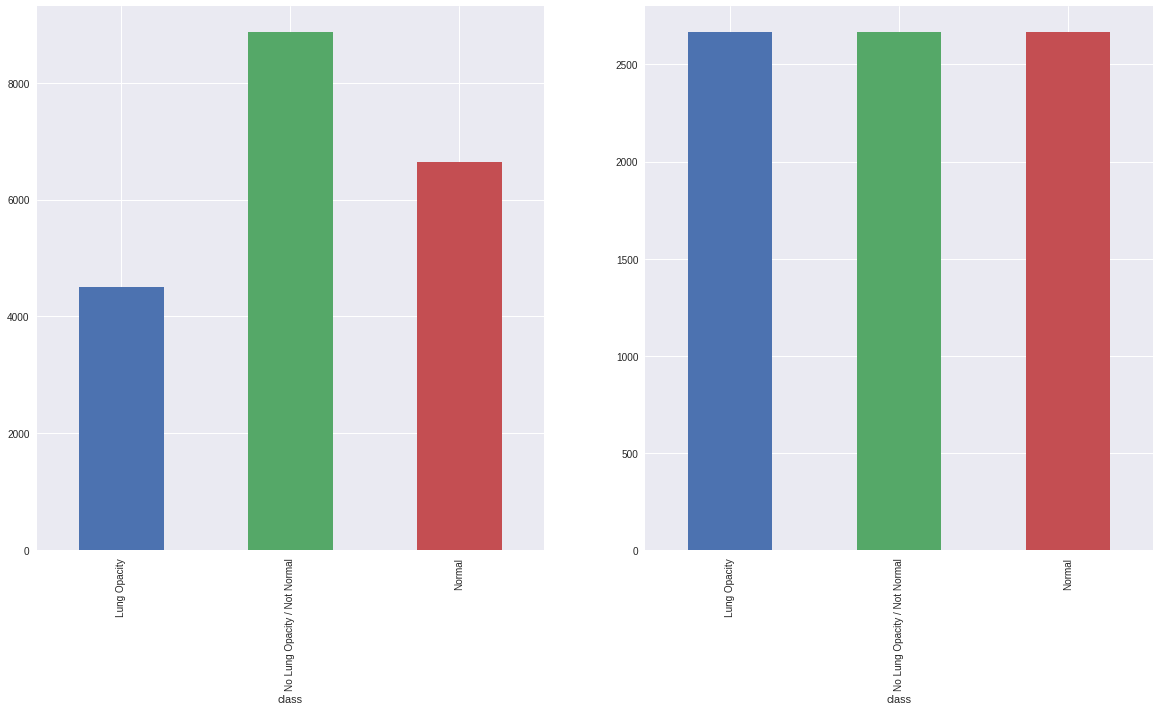

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
df_training_data.groupby('class').size().plot.bar(ax=ax1)
train_df = df_training_data.groupby('class').\
    apply(lambda x: x.sample(network_config["TRAIN_SAMPLES"]//3)).\
    reset_index(drop=True)
train_df.groupby('class').size().plot.bar(ax=ax2) 
print(train_df.shape[0], 'new training size')

In [0]:
!python -c "import keras; print(keras.__version__)"

Using TensorFlow backend.
2.2.4


In [0]:
print(tf.VERSION)

1.10.0


In [0]:
img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.05, 
                              width_shift_range = 0.02, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05,
                              preprocessing_function=preprocess_input)



img_generator = tf.keras.preprocessing.image.ImageDataGenerator(**img_gen_args)

In [0]:

def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, seed = None, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways: seed: {}'.format(seed))
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                               seed = seed,
                                             **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values,0)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [0]:

 
train_generator = flow_from_dataframe(img_generator, train_df, 
                             path_col = 'path',
                            y_col = 'class_vec', 
                            target_size = network_config["IMG_SIZE"],
                             color_mode = 'rgb',
                            batch_size = network_config["BATCH_SIZE"],
                           interpolation='nearest'      )
  
  
valid_generator = flow_from_dataframe(img_generator, df_validation_data, 
                             path_col = 'path',
                            y_col = 'class_vec', 
                            target_size = network_config["IMG_SIZE"],
                             color_mode = 'rgb',
                            batch_size = 256,
                            interpolation='nearest')


valid_X, valid_Y  = next(flow_from_dataframe(img_generator, 
                               df_validation_data, 
                             path_col = 'path',
                             y_col = 'class_vec', 
                            target_size = network_config["IMG_SIZE"],
                            color_mode = 'rgb',
                            batch_size = network_config["TEST_SAMPLES"],
                            interpolation='nearest'))  
 
 
 

## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
Reinserting dataframe: 7998 images
## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
Reinserting dataframe: 6671 images
## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
Reinserting dataframe: 6671 images


(24, 384, 384, 3) (24, 3)


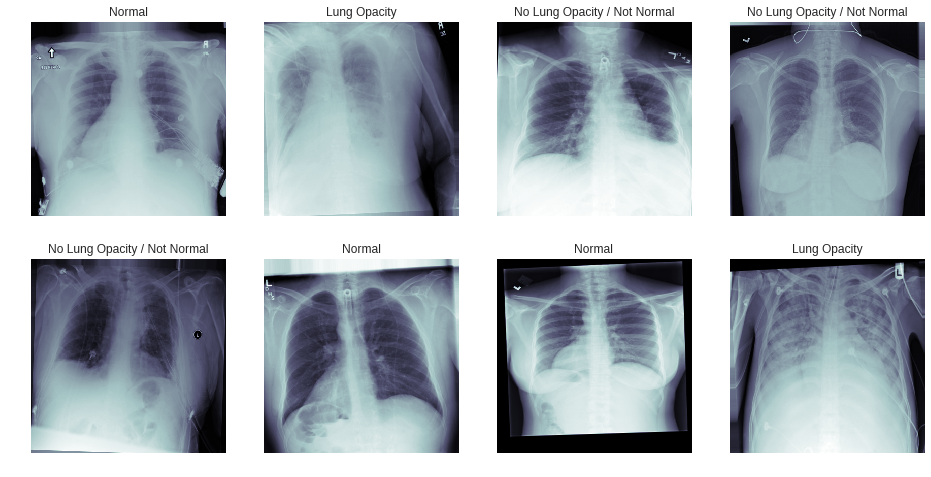

In [0]:
t_x, t_y = next(train_generator)
print(t_x.shape, t_y.shape)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    c_ax.set_title('%s' % encode_classes.classes_[np.argmax(c_y)])
    c_ax.axis('off')
 

In [0]:
t_x.shape

(24, 384, 384, 3)

In [0]:
t_y.shape

(24, 3)

In [0]:
# download weights
VGG16pretrained_model = VGG16(  input_shape=t_x.shape[1:], include_top = False, weights = 'imagenet')

# train only the top layers (which were randomly initialized)                      
VGG16pretrained_model.trainable = False
 


In [0]:

pt_features = Input(VGG16pretrained_model.get_output_shape_at(0)[1:], name = 'feature_input')
bn_features = BatchNormalization()(pt_features)
gap = GlobalAveragePooling2D()(bn_features) 
gap_dr = Dropout(network_config["DROPOUT"])(gap)
dr_steps = Dropout(network_config["DROPOUT"])(Dense(network_config["DENSE_COUNT"], activation = 'linear', use_bias=False)(gap_dr))
dr_steps = BatchNormalization()(dr_steps)
dr_steps = layers.LeakyReLU(0.1)(dr_steps)
out_layer = Dense(3, activation = 'softmax')(dr_steps)

trained_model = Model(inputs = [pt_features], 
                   outputs = [out_layer])
 
trained_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_input (InputLayer)   (None, 12, 12, 512)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 512)       2048      
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65536     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
__________

In [0]:
rsnaPneumonia_model = Sequential(name = 'combined_model')

rsnaPneumonia_model.add(VGG16pretrained_model)
 
rsnaPneumonia_model.add(trained_model)
rsnaPneumonia_model.compile(optimizer = Adam(lr = network_config["LEARN_RATE"]), loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy'])
rsnaPneumonia_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 12, 12, 512)       14714688  
_________________________________________________________________
model_2 (Model)              (None, 3)                 68483     
Total params: 14,783,171
Trainable params: 67,203
Non-trainable params: 14,715,968
_________________________________________________________________


In [0]:

weight_path="{}_weights.best.hdf5".format('lung_opacity')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                   patience=10, verbose=1, mode='auto', 
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
train_generator.batch_size = network_config["BATCH_SIZE"] 
rsnaPneumonia_model.fit_generator(train_generator, 
                         steps_per_epoch=train_generator.n//network_config["BATCH_SIZE"] ,
                         validation_data=(valid_X, valid_Y), 
                         epochs=20, 
                         callbacks=callbacks_list,
                         workers=2)

Epoch 1/20


In [0]:
callbacks_list